# 1. Install Dependencies and Setup

In [1]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip list

Package                      Version
---------------------------- ---------
absl-py                      1.3.0
aiohttp                      3.8.3
aiohttp-retry                2.8.3
aiosignal                    1.2.0
altgraph                     0.17.2
amqp                         5.1.1
antlr4-python3-runtime       4.9.3
appdirs                      1.4.4
astunparse                   1.6.3
async-generator              1.10
async-timeout                4.0.2
asyncssh                     2.12.0
atpublic                     3.1.1
attrs                        21.4.0
auto-py-to-exe               2.18.0
backcall                     0.2.0
beautifulsoup4               4.10.0
billiard                     3.6.4.0
bottle                       0.12.19
bottle-websocket             0.2.9
bs4                          0.0.1
cachetools                   5.2.0
celery                       5.2.7
certifi                      2021.10.8
cffi                         1.15.0
charset-normalizer           2.0.12


In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
#tf.config.list_physical_devices('GPU')

# 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = r'C:\Users\msoli\uae-chapter-road-inspection\src\data' 

In [8]:
os.listdir(data_dir)

['Cracks', 'Groove']

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
# reading image sample
image = cv2.imread(os.path.join(data_dir,'Cracks','Cracks_(22).jpg'))
image.shape


(640, 1024, 3)

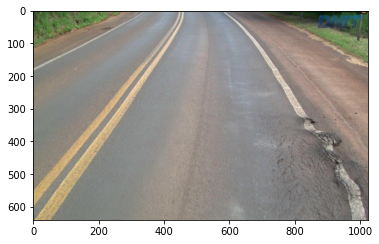

In [11]:
from matplotlib import pyplot as plt

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));


In [12]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [13]:
#tf.data.Dataset??

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
# building data pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(300, 300))

Found 2096 files belonging to 2 classes.


In [16]:
data

<BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
# loop
data_iterator = data.as_numpy_iterator()

In [18]:
# Get another batch from iterator
batch = data_iterator.next()

In [19]:
batch[0][0]

array([[[ 83.695335 ,  79.695335 ,  50.69533  ],
        [ 54.246666 ,  57.99267  ,  28.537334 ],
        [ 22.966667 ,  32.12889  ,   7.5477786],
        ...,
        [ 73.747734 ,  67.747734 ,  51.747734 ],
        [ 68.96198  ,  65.96198  ,  50.961983 ],
        [ 87.443115 ,  85.443115 ,  72.443115 ]],

       [[ 83.08     ,  79.08     ,  52.079998 ],
        [ 58.552002 ,  63.04     ,  35.606003 ],
        [ 30.509998 ,  40.51     ,  16.22     ],
        ...,
        [ 84.38006  ,  79.38006  ,  60.380054 ],
        [ 79.55001  ,  76.55001  ,  61.55001  ],
        [ 70.62134  ,  68.62134  ,  53.621334 ]],

       [[ 82.316666 ,  76.994446 ,  52.655556 ],
        [ 64.03333  ,  67.48     ,  42.756664 ],
        [ 24.166664 ,  33.327774 ,  11.844442 ],
        ...,
        [ 90.41113  ,  85.41113  ,  66.41113  ],
        [ 65.18333  ,  62.183327 ,  45.183327 ],
        [ 71.06333  ,  69.06333  ,  54.063335 ]],

       ...,

       [[208.71526  , 180.26096  , 111.86324  ],
        [16

In [20]:
# Images represented as numpy arrays
batch[0].shape

(32, 300, 300, 3)

In [21]:
# Class 1 = Groove
# Class 0 = Crack
batch[1]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0])

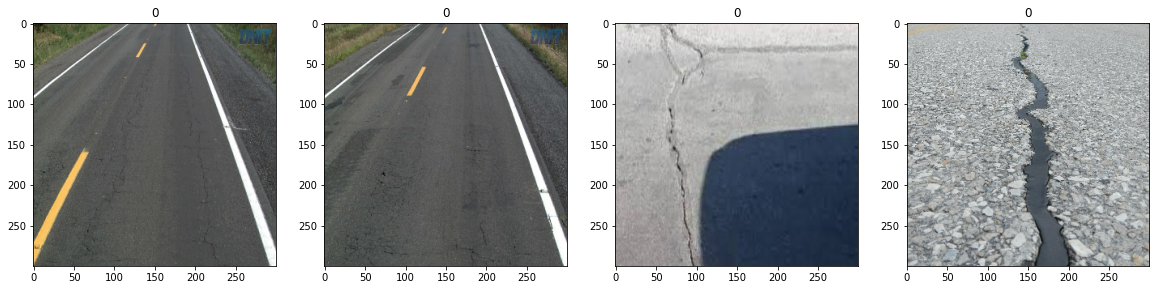

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Class 1 = Groove
# Class 0 = Crack

In [23]:
batch[0].min()

0.0

In [24]:
batch[0].max()

255.0

# 4. Scale Data
scale is helping our deep learning model generalize faster and produces better results

In [25]:
data = data.map(lambda x,y: (x/255, y))

In [26]:
data.as_numpy_iterator().next()[0].max()

1.0

# 5. Split Data

In [27]:
len(data)

66

In [28]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [29]:
train_size, val_size, test_size

(46, 13, 6)

In [30]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [31]:
len(train)

46

# 6. Build Deep Learning Model
build deep learning model using the keras sequential api

In [32]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [34]:
model = Sequential()

In [35]:
#MaxPooling2D??

In [36]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(300,300,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [37]:
#model.compile??

In [38]:
#tf.optimizers??

In [39]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 16)       0

# 7. Train

In [41]:
logdir=r'C:\Users\msoli\uae-chapter-road-inspection\src\logs'

In [42]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [43]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

'''
epochs is how long we're actually
going to go ahead and train for, and 
one epoch is one run over our entire
training set of data.
'''

Epoch 1/10
46/46 [==============================] - 53s 1s/step - loss: 0.6315 - accuracy: 0.6827 - val_loss: 0.5900 - val_accuracy: 0.5240
Epoch 2/10
46/46 [==============================] - 52s 1s/step - loss: 0.4667 - accuracy: 0.7425 - val_loss: 0.5318 - val_accuracy: 0.7812
Epoch 3/10
46/46 [==============================] - 52s 1s/step - loss: 0.3933 - accuracy: 0.8444 - val_loss: 0.4035 - val_accuracy: 0.8149
Epoch 4/10
46/46 [==============================] - 52s 1s/step - loss: 0.3265 - accuracy: 0.8601 - val_loss: 0.3655 - val_accuracy: 0.8389
Epoch 5/10
46/46 [==============================] - 52s 1s/step - loss: 0.3004 - accuracy: 0.8709 - val_loss: 0.4164 - val_accuracy: 0.8245
Epoch 6/10
46/46 [==============================] - 52s 1s/step - loss: 0.2882 - accuracy: 0.8899 - val_loss: 0.4454 - val_accuracy: 0.8293
Epoch 7/10
46/46 [==============================] - 52s 1s/step - loss: 0.2572 - accuracy: 0.8995 - val_loss: 0.4054 - val_accuracy: 0.8341
Epoch 8/10
46/46 [==

"\nepochs is how long we're actually\ngoing to go ahead and train for, and \none epoch is one run over our entire\ntraining set of data.\n"

In [44]:
hist.history

{'loss': [0.6315286755561829,
  0.4667474031448364,
  0.3933280408382416,
  0.32654228806495667,
  0.300445020198822,
  0.2882474362850189,
  0.2572476267814636,
  0.2387184500694275,
  0.1713111400604248,
  0.15260978043079376],
 'accuracy': [0.682744562625885,
  0.742527186870575,
  0.8444293737411499,
  0.8600543737411499,
  0.8709239363670349,
  0.8899456262588501,
  0.8994565010070801,
  0.9089673757553101,
  0.9273098111152649,
  0.9375],
 'val_loss': [0.5899773240089417,
  0.5317848920822144,
  0.40347105264663696,
  0.36551862955093384,
  0.4163891673088074,
  0.4454437792301178,
  0.4053943455219269,
  0.3470158874988556,
  0.3844769597053528,
  0.34091541171073914],
 'val_accuracy': [0.5240384340286255,
  0.78125,
  0.8149038553237915,
  0.838942289352417,
  0.8245192170143127,
  0.8293269276618958,
  0.8341346383094788,
  0.8605769276618958,
  0.8533653616905212,
  0.8846153616905212]}

# 8. Plot Performance

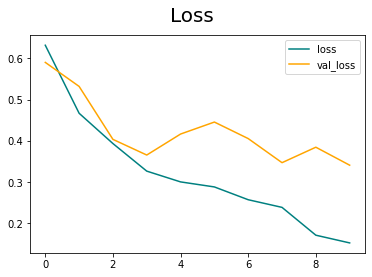

In [45]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

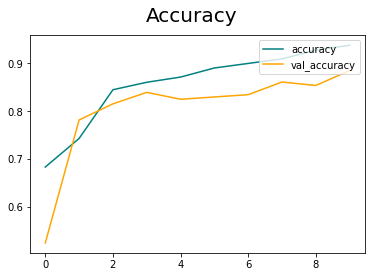

In [46]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper right")
plt.show()

# 9. Evaluate

In [47]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [48]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [49]:
len(test)

6

In [50]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 180ms/step


In [51]:
pre.result().numpy(), re.result().numpy(), acc.result().numpy()

(0.8557692, 0.90816325, 0.875)

# 10. Test

In [52]:
import cv2

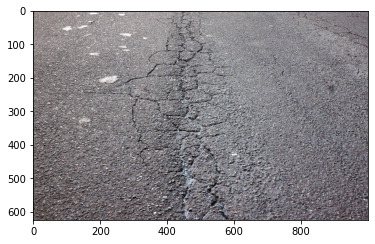

In [53]:
img = cv2.imread(r'C:\Users\msoli\uae-chapter-road-inspection\CrackTest2.jpg')
plt.imshow(img)
plt.show()

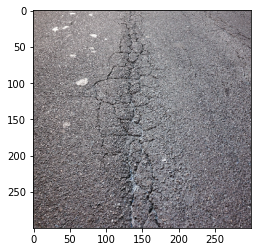

In [54]:
resize = tf.image.resize(img, (300,300))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [55]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 82ms/step


array([[0.00076004]], dtype=float32)

In [56]:
if yhat > 0.5: 
    print(f'Predicted class is Groove')
else:
    print(f'Predicted class is Crack')

Predicted class is Crack


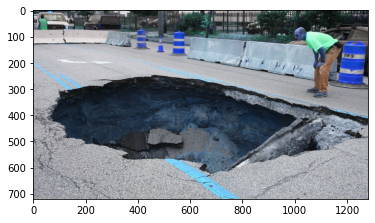

In [57]:
img2 = cv2.imread(r'C:\Users\msoli\uae-chapter-road-inspection\grooveTest2.jpg')
plt.imshow(img2)
plt.show()

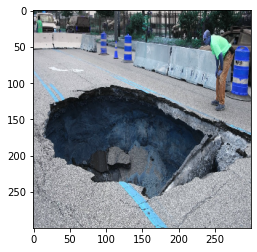

In [58]:
resize2 = tf.image.resize(img2, (300,300))
plt.imshow(resize2.numpy().astype(int))
plt.show()

In [59]:
yhat = model.predict(np.expand_dims(resize2/255, 0))
yhat

1/1 [==============================] - 0s 26ms/step


array([[0.9999031]], dtype=float32)

In [60]:
if yhat > 0.5: 
    print(f'Predicted class is Groove')
else:
    print(f'Predicted class is Crack')

Predicted class is Groove


# 11. Save the Model

In [61]:
from tensorflow.keras.models import load_model

In [62]:
model.save(os.path.join('models','CrackGrooveClassifierModel.h5'))

In [63]:
new_model = load_model(os.path.join('models','CrackGrooveClassifierModel.h5'))

In [64]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 71ms/step


array([[0.00076004]], dtype=float32)